<a href="https://colab.research.google.com/github/psukphranee/SAR/blob/main/SAR_Revision_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import scipy.sparse as sp

#I. Introduction

> A satellite antenna emits a chirp pulse train towards the ground some distance away. The signal has a PRF of 10kHz with 10% duty-time. The signal bounces off of the ground directly back at the antenna. The antenna picks the signal up at a sampling rate of 1GHz. The ground will be model as an LTI system. Thus, the reflected signal is the convolution of the incoming signal (incoming into the ground) with the impulse response of the ground.

 > This notebook will give a rundown of the principles involved and implementation details and logic using Python. 

 Steps involved are **Pulse Generation**, input into **Ground Model**, and examine the **Output**.



# II. Pulse Generation

The signal is described by

$P(t) = \chi_{\tau}(t) e^{j 2 \pi (f_c t + \frac{1}{2}k t^2)}$,
where 
$
\chi_{\tau}(t)=
    \begin{cases}
        A & \text{if } t \in [0, \tau] \\
        0 & otherwise
    \end{cases}
$

## A. Carrier Frequency and Chirp Rate Constraints
The **pulse width**, $\tau$, is calculated as the duty time divided by the pulse repetition frequency,

$
\tau = \dfrac{D}{PRF} = \dfrac{.1}{10^4} = 10^{-5}s.
$

We can choose our carrier frequency and chirp rate so that we don't exceed $f_m = 500MHz$ over the pulse duration $\tau$.

$f_c + \dfrac{10^{-5}}{2}k < 500MHz$.

In [3]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

#@title Pulse Parameters
#@markdown Duty Time:  $[\%]$
D = 10 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Pulse Reptitition Frequency (PRF) $[kHz]$
PRF = 1 #@param {type:"slider", min:0, max:20, step:1}
#@markdown $k:  [\frac{MHz}{s}]$
k = 26 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Carrier Frequency:  $[MHz]$
f_c = 100 #@param {type:"slider", min:0, max:500, step:5}
#@markdown Sampling Frequency:  $[MHz]$
f_s = 30 #@param {type:"slider", min:0, max:500, step:5}

#scale input parameters by their suffix
D = D * .01;
PRF = PRF * 10e3;
k = k * 10e6;
f_c = f_c * 10e6;
f_s = f_s * 10e6;

#calculate other parameters from input parameters
PRT = np.reciprocal(PRF);
f_m = f_s/2;
tau = D*PRT;

#
A = 1 #pulse height

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


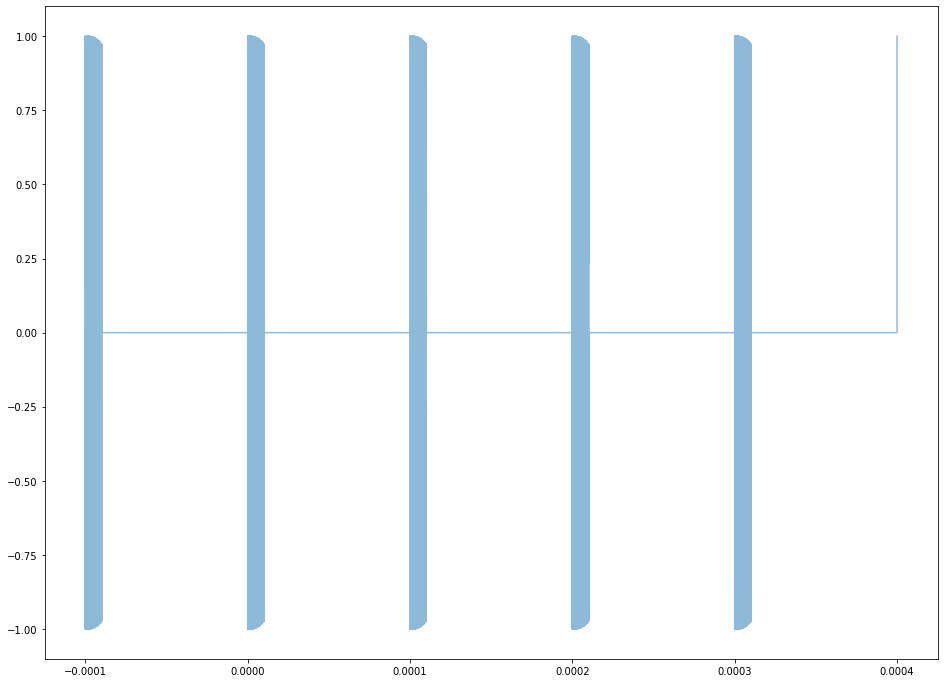

In [10]:
# Display the message within the output widget.
t_end = PRT*4 #multiple of pulse repittion period
t = np.linspace(-1*PRT, t_end, int(f_s*t_end)).reshape(1,-1)
t_mod = np.mod(t, PRT)

pulse = generate_LFM_Pulse(time_array=t_mod, pulse_width=tau, pulse_height=1, chirp_rate=k, carrier_frequency=f_c)

plt.figure(figsize=(16, 12))
plt.plot(t[0,:], pulse[0,:], alpha=0.5)
plt.show()

In [4]:
def generate_pulse_envelope(time_array, pulse_width=1e-5, pulse_height=1):
  #this function returns pulse envelopes of tau width wide. the left edge of the envelope is located at any zeros of the time array.

  t = time_array;
  A = pulse_height;
  tau = pulse_width; 
  tau_half = tau/2;

  chi = A * (np.abs((t-tau_half)/tau_half) <= 1);

  return chi;

#---------------------------------------------------------------------------------------------#
def generate_pulse_wave(time_array, chirp_rate=0, carrier_frequency=500e6):
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency
  # #argument to be passed to exponenetial 
  exp_arg = 2j*np.pi*(f_c*t + .5*k*(np.square(t)))
  LFM = np.exp(exp_arg);

  return LFM

#---------------------------------------------------------------------------------------------#
def generate_LFM_Pulse(time_array, pulse_width=1, pulse_height=1, chirp_rate=1, carrier_frequency=100):
  
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #pulse envelope  ---------------
  chi = generate_pulse_envelope(t, pulse_height=pulse_height, pulse_width=pulse_width);

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency

  LFM = generate_pulse_wave(t, k, f_c)

  pulse = chi * LFM;

  return pulse

#---------------------------------------------------------------------------------------------#
def plot_train(time_absolute, time_modulus, train):

  fig, ax = plt.subplots(2,1, figsize=(20,8))
  ax[0].plot(t[0,:], train[0,:], alpha=0.5)
  ax[1].plot(t[0,:], t_mod[0,:], alpha=0.5)

  # ax[0].set_title("Pulse Envelope")
  ax[1].set_title("Verify Periodicity")
  plt.show()